In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Leases data
leases_df = pd.read_csv("../../data/Leases.csv")

# Create a combined year_quarter column
leases_df["year_quarter"] = leases_df["year"].astype(str) + " " + leases_df["quarter"]

# Filter out rows with missing availability_proportion or rent
filtered_df = leases_df[
    (leases_df["availability_proportion"].notna()) &
    (leases_df["overall_rent"].notna())
].copy()

# Group by market and year_quarter to compute average availability and rent
market_trends = (
    filtered_df.groupby(["market", "year_quarter"])
    .agg(
        avg_availability=("availability_proportion", "mean"),
        avg_rent=("overall_rent", "mean")
    )
    .reset_index()
)

# Plot usage recovery = 1 - avg_availability
plt.figure(figsize=(16, 10))
sns.lineplot(
    data=market_trends,
    x="year_quarter",
    y=1 - market_trends["avg_availability"],
    hue="market",
    marker="o"
)

plt.title("Occupancy Recovery Over Time by Market (1 - Availability Proportion)", fontsize=16)
plt.xlabel("Year - Quarter")
plt.ylabel("Usage Rate (1 - Availability)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Market", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig("../../plots/occupany_recovery_by_market.png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
%matplotlib inline
import plotly.graph_objects as go

# Step 2: Load Leases.csv
leases = pd.read_csv("../../data/Leases.csv")

# Step 3: Aggregate total leased square footage by market and quarter
leases_grouped = (
    leases.groupby(['year', 'quarter', 'market'])['leasedSF']
    .sum()
    .reset_index()
    .rename(columns={'leasedSF': 'total_leasedSF'})
)

# Step 4: Filter for the latest available quarter
latest_year = leases_grouped['year'].max()
latest_quarter = leases_grouped[leases_grouped['year'] == latest_year]['quarter'].max()

latest_leases = leases_grouped[
    (leases_grouped['year'] == latest_year) & (leases_grouped['quarter'] == latest_quarter)
]

# Step 5: Map markets to U.S. states using original leases file
market_state_map = leases[['market', 'state']].drop_duplicates()
leases_with_states = pd.merge(latest_leases, market_state_map, on='market', how='left')

# Step 6: Aggregate to state-level totals
leases_by_state = leases_with_states.groupby('state')['total_leasedSF'].sum().reset_index()

# Step 7: Plot on U.S. map
fig = go.Figure(data=go.Choropleth(
    locations=leases_by_state['state'],             # State abbreviations (e.g., 'CA', 'TX')
    z=leases_by_state['total_leasedSF'],            # Data to color-code
    locationmode='USA-states',
    colorscale='Viridis',
    colorbar_title="Leased SF"
))

fig.update_layout(
    title_text=f'Total Leased Square Footage by State — {latest_quarter} {latest_year}',
    geo=dict(scope='usa'),
)

fig.show()
fig.write_html("../../plots/leased_square_footage_map.html")

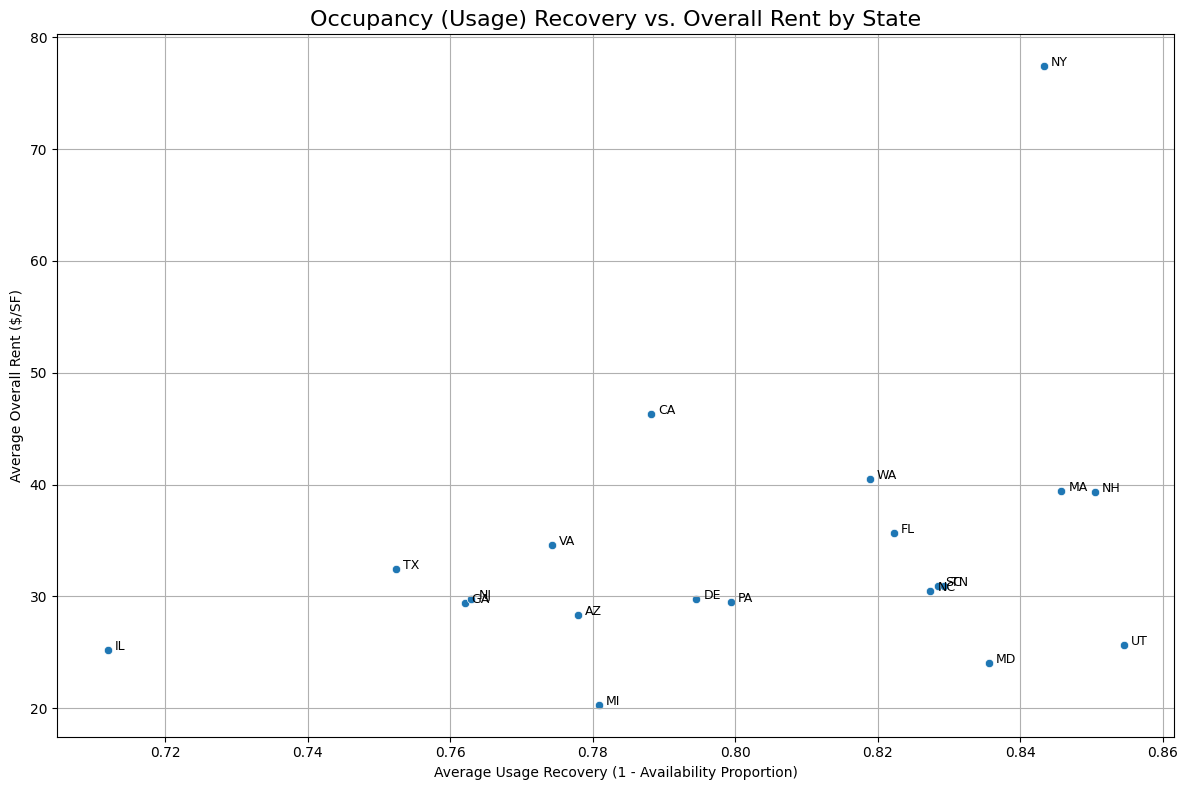

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Leases data
leases_df = pd.read_csv("../../data/Leases.csv")

# Filter out rows with missing values
filtered_df = leases_df[
    (leases_df["availability_proportion"].notna()) &
    (leases_df["overall_rent"].notna()) &
    (leases_df["state"].notna())
].copy()

# Compute usage recovery = 1 - availability proportion
filtered_df["usage_recovery"] = 1 - filtered_df["availability_proportion"]

# Group by state: average usage recovery and average rent
state_level = (
    filtered_df.groupby("state")
    .agg(
        avg_usage_recovery=("usage_recovery", "mean"),
        avg_overall_rent=("overall_rent", "mean")
    )
    .reset_index()
)

# Plot: Usage Recovery vs Overall Rent by State
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=state_level,
    x="avg_usage_recovery",
    y="avg_overall_rent"
)

# Add text labels for each state
for i in range(state_level.shape[0]):
    plt.text(
        x=state_level["avg_usage_recovery"][i] + 0.001,
        y=state_level["avg_overall_rent"][i],
        s=state_level["state"][i],
        fontsize=9
    )

plt.title("Occupancy (Usage) Recovery vs. Overall Rent by State", fontsize=16)
plt.xlabel("Average Usage Recovery (1 - Availability Proportion)")
plt.ylabel("Average Overall Rent ($/SF)")
plt.grid(True)
plt.tight_layout()

# Save the plot to file
plt.savefig("../../plots/usage_vs_rent_price_by_state.png", dpi=300, bbox_inches='tight')
plt.show()

/Users/sharad/miniconda3/envs/myenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16765
           1       1.00      1.00      1.00     12344

    accuracy                           1.00     29109
   macro avg       1.00      1.00      1.00     29109
weighted avg       1.00      1.00      1.00     29109



/Users/sharad/miniconda3/envs/myenv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


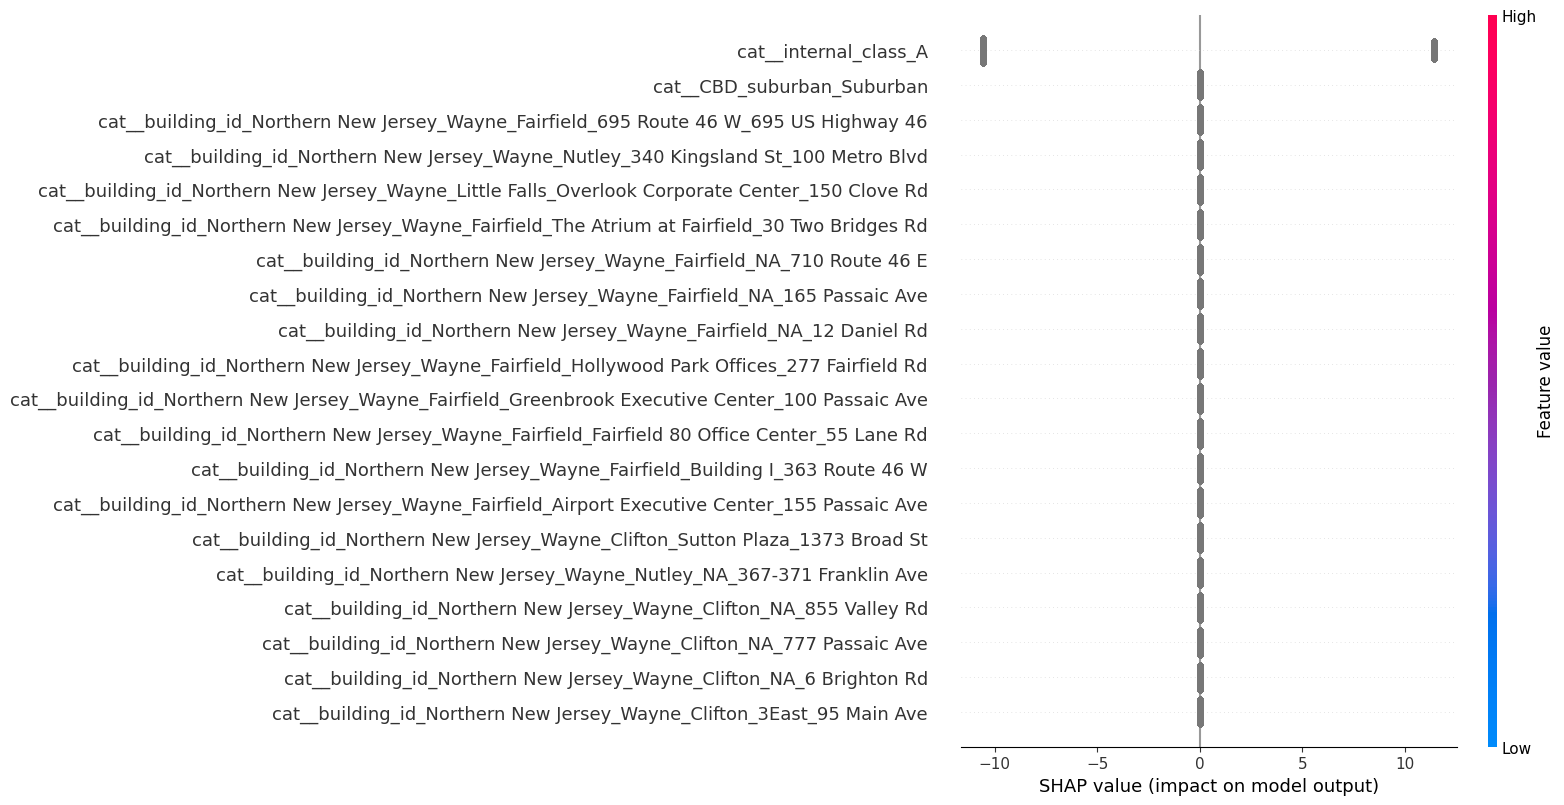

FileNotFoundError: [Errno 2] No such file or directory: '../../plot/shap_internal_class_with_rent.png'

<Figure size 640x480 with 0 Axes>

In [ ]:

#Code for predicting internal class

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

# Load data
leases_df = pd.read_csv("../../data/Leases.csv")

# Drop rows with missing target and required features
leases_df = leases_df[
    leases_df["internal_class"].notna() &
    leases_df["overall_rent"].notna()
]

# Features to use for prediction
features = [
    "year","quarter","monthsigned","market","b,"building_id","address","region","city","state","zip","internal_submarket","internal_class","leasedSF","company_name","internal_industry","transaction_type","internal_market_cluster","costarID","space_type","CBD_suburban","RBA","available_space","availability_proportion","internal_class_rent","overall_rent","direct_available_space","direct_availability_proportion","direct_internal_class_rent","direct_overall_rent","sublet_available_space","sublet_availability_proportion","sublet_internal_class_rent","sublet_overall_rent","leasing"
]
X = leases_df[features]
y = leases_df["internal_class"].map({"O": 0, "A": 1})

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numeric and categorical data
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformations
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Build pipeline with classifier
clf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42))
])

# Fit model
clf_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# --- SHAP Analysis ---
X_transformed = clf_pipeline.named_steps["preprocessor"].transform(X_test)
feature_names = clf_pipeline.named_steps["preprocessor"].get_feature_names_out()

explainer = shap.Explainer(clf_pipeline.named_steps["classifier"])
shap_values = explainer(X_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)
plt.savefig("../../plot/shap_internal_class_with_rent.png", dpi=300, bbox_inches="tight")


In [ ]:
#Code for predicting Absorption


import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt

# Load data
leases_df = pd.read_csv("../../data/Leases.csv")

# Drop rows with missing key values
leases_df = leases_df[
    leases_df["leasedSF"].notna() &
    leases_df["RBA"].notna() &
    leases_df["state"].notna() &
    leases_df["internal_class"].notna()
].copy()

# Step 1: Calculate average RBA per (state, internal_class)
avg_rba_map = (
    leases_df.groupby(["state", "internal_class"])["RBA"]
    .mean()
    .reset_index()
    .rename(columns={"RBA": "rba_by_class_state"})
)

# Merge that back into original data
leases_df = leases_df.merge(avg_rba_map, on=["state", "internal_class"], how="left")

# Compute absorption
leases_df["absorption"] = leases_df["leasedSF"] / leases_df["rba_by_class_state"]

# Drop rows with invalid absorption (just in case)
leases_df = leases_df[leases_df["absorption"].notna() & (leases_df["absorption"] < 1.5)]

# Define features
features = [
    "leasedSF", "availability_proportion", "CBD_suburban", "space_type",
    "RBA", "available_space", "region", "state", "overall_rent"
]
X = leases_df[features]
y = leases_df["absorption"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="mean"))])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Model pipeline
reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(n_estimators=100, random_state=42))
])

# Train
reg_pipeline.fit(X_train, y_train)

# Predict
y_pred = reg_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.4f}")

# --- SHAP Analysis ---
X_transformed = reg_pipeline.named_steps["preprocessor"].transform(X_test)
feature_names = reg_pipeline.named_steps["preprocessor"].get_feature_names_out()

explainer = shap.Explainer(reg_pipeline.named_steps["regressor"])
shap_values = explainer(X_transformed)

# SHAP violin-style plot
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)
plt.savefig("../../plot/shap_absorption.png", dpi=300, bbox_inches="tight")
